### How does your work express information about cultural influence of music in time or circumstances? Alternatively, how can the effects of social, political or technological changes (such as the internet) be identified within the network?

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [3]:
artists = pd.read_csv('data_by_artist.csv')
artists = artists.drop_duplicates(subset='artist_name', keep='last')
years = pd.read_csv('data_by_year.csv')
influence = pd.read_csv('influence_data.csv')

In [58]:
from tqdm import tqdm
#remove songs by artists that arent in the artists table
#duplicate songs w/ more than one artist
#takes my computer about a minute to run
#can ignore the warnings about setting a copy of a slice from a dataframe
full = pd.read_csv('full_music_data.csv')
allArtists = list(artists['artist_id'])
newdict = {}

full['artists_id'] = [int(x.split(',')[0][1:-1]) if len(x.split(',')) == 1 else [int(y) for y in x[1:-1].split(',')] for x in list(full['artists_id'])]
full['artist_names'] = [ast.literal_eval(x) if len(ast.literal_eval(x)) > 1 else ast.literal_eval(x)[0] for x in full['artist_names']]
floor = min(full['tempo'])
span = max(full['tempo']) - floor
full['tempo'] = [(x-floor)/span for x in full['tempo']]

last_id = 0
row = 0
for i in tqdm(range(len(full))): 
    thisRow = full.iloc[i,:]
    artIDs = thisRow['artists_id']
    artNames = thisRow['artist_names']
    
    if type(artIDs) == int:
        if artIDs == last_id: 
            thisRow['artists_id'] = artIDs
            thisRow['artist_names'] = artNames
            newdict[row] = thisRow.to_dict()
            row+=1
            last_id = artIDs
        else:
            if artIDs in allArtists:
                thisRow['artists_id'] = artIDs
                thisRow['artist_names'] = artNames
                newdict[row] = thisRow.to_dict()
                row+=1
                last_id = artIDs
                
    else:
        for j in range(len(artIDs)):
            artID = int(artIDs[j])
            artName = str(artNames[j])
            
            if artID in allArtists:
                thisRow['artists_id'] = artID
                thisRow['artist_names'] = artName
                newdict[row] = thisRow.to_dict()
                row+=1
    i+=1

full = pd.DataFrame.from_dict(newdict,'index')

artistGenres = {} #adds song genre to full
for i in tqdm(range(len(influence))):
    row = influence.iloc[i]
    influencer = row['influencer_id']
    follower = row['follower_id']
    infGenre = row['influencer_main_genre']
    folGenre = row['follower_main_genre']
    artistGenres[influencer] = infGenre
    artistGenres[follower] = folGenre

def getGenre(row):
    artist = row['artists_id']
    if type(artist) == list:
        print(row)
    try:
        genre = artistGenres[artist]
    except KeyError:
        genre = 'N/A'
    return genre

full['genre'] = full.apply(lambda row: getGenre(row), axis = 1)

full.head()


  0%|                                                                                        | 0/98340 [00:00<?, ?it/s]C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre
0,Fat Freddy's Drop,178301,0.600,0.365,0.131,0.532777,-13.083,0,9,0.0672,0.585000,0.0921,0.0498,0,437200,54,2005,2005,Ernie,Electronic
1,Fat Freddy's Drop,178301,0.874,0.326,0.179,0.490063,-13.302,0,11,0.0136,0.148000,0.0993,0.1310,0,581008,53,2005,2005,Wandering Eye,Electronic
2,Fat Freddy's Drop,178301,0.670,0.531,0.336,0.571037,-8.267,0,9,0.0156,0.345000,0.3060,0.0377,0,431293,55,2009,8/7/2009,The Raft,Electronic
3,Alexander O'Neal,625201,0.761,0.702,0.850,0.429237,-8.523,1,7,0.1080,0.000031,0.0935,0.0389,0,304427,34,1991,1/1/1991,All True Man,R&B;
4,Alexander O'Neal,625201,0.661,0.828,0.902,0.471455,-12.673,0,11,0.2760,0.000001,0.2870,0.0390,0,264933,37,1987,7/29/1987,(What Can I Say) To Make You Love Me,R&B;


In [4]:
#list artist names
names = []
for i in artists['artist_name']:
    names.append(i)

# refine influence df    
influence = influence[influence['influencer_name'].isin(names)]
influence = influence[influence['follower_name'].isin(names)]
influence = influence.reset_index(drop=True)
influence.head()


# list genres
genre = []
for i in influence['influencer_main_genre']:
    if i not in genre:
        genre.append(i)
for i in influence['follower_main_genre']:
    if i not in genre:
        genre.append(i)
       
    
# dict of genres paired w their artists
artistByGenre = {}
for i in genre:
    artistByGenre[i] = []
i = 0
while i < len(influence):
    genreList = artistByGenre.get(influence['influencer_main_genre'][i])
    genreListF = artistByGenre.get(influence['follower_main_genre'][i])
    if influence['influencer_name'][i] not in genreList:
        genreList.append(influence['influencer_name'][i])
    if influence['follower_name'][i] not in genreListF:
        genreListF.append(influence['follower_name'][i])
    i += 1

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """


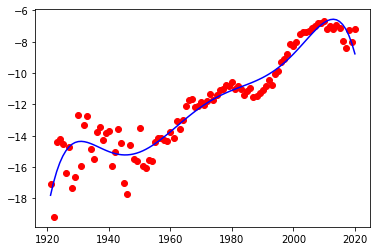

In [8]:
#Digital signal processing invented in 1990s, allowing music to be compressed and louder
year = years['year']
attribute = years['loudness']
plt.plot(year, attribute, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 9))(np.unique(year)), '-b')

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


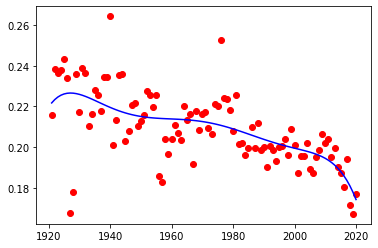

In [32]:
year = years['year']
attribute = years['liveness']
plt.plot(year, attribute, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 9))(np.unique(year)), '-b')

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


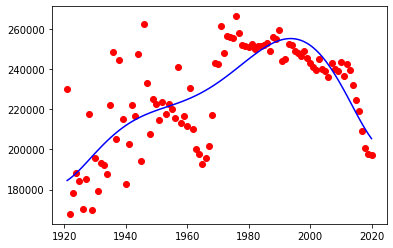

In [14]:
#Social media and internet became widespread in the 1990s, leading to a decline in attention span
year = years['year']
attribute = years['duration_ms']
plt.plot(year, attribute, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 9))(np.unique(year)), '-b')

In [19]:
socialMedia = years[years['year'] > 1997]
socialMedia = socialMedia.reset_index(drop=True)
(socialMedia['duration_ms'][0] - socialMedia['duration_ms'][len(socialMedia) - 1]) / socialMedia['duration_ms'][0] * 100

20.785705753602475

In [34]:
influence

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start,Follow Count
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980,NaN
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990,NaN
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990,NaN
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990,NaN
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990,NaN
...,...,...,...,...,...,...,...,...,...
42765,580300,Sufjan Stevens,Pop/Rock,1990,3661738,Rosemary & Garlic,Pop/Rock,2010,NaN
42766,261309,Vybz Kartel,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010,NaN
42767,467203,Michael Jackson,R&B;,1960,3670556,Trinidad Cardona,R&B;,2010,NaN
42768,2518003,Popcaan,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010,NaN


In [59]:
popInfluence = influence[influence['follower_main_genre'] == 'Pop/Rock']
FollowCount = pd.DataFrame(popInfluence['follower_name'].value_counts())
FollowCount = FollowCount.reset_index()
FollowCount = FollowCount.rename(columns={'index': 'Artist', 'follower_name' : 'Number of Influences'})
start = []
for i in FollowCount['Artist']:
    df = influence[influence['follower_name'] == i]
    df = df.reset_index(drop=True)
    start.append(df['follower_active_start'][0])
FollowCount['Start'] = pd.Series(start)
FollowCount


,Artist,Number of Influences,Start
0,The Darkness,47,2000
1,Norah Jones,44,2000
2,Matthew Sweet,43,1980
3,Blur,41,1980
4,Beck,40,1990
...,...,...,...
2671,John D. Loudermilk,1,1950
2672,Terry Jacks,1,1970
2673,Len,1,1990
2674,Eluveitie,1,2000


In [60]:
countGroups = FollowCount.groupby(['Start']).mean()
countGroups = countGroups.sort_values(by=['Start'])
countGroups = countGroups.reset_index()
countGroups

,Start,Number of Influences
0,1930,8.000000
1,1940,6.500000
2,1950,8.422222
3,1960,10.397297
4,1970,11.210256
5,1980,10.828814
6,1990,11.361538
7,2000,8.546809
8,2010,4.398230


C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


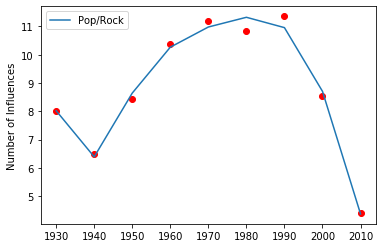

In [65]:
year = countGroups['Start']
attribute = countGroups['Number of Influences']
plt.plot(year, attribute, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 7))(np.unique(year)), label='Pop/Rock')
plt.ylabel('Number of Influences')
plt.legend()

In [57]:
full

NameError: name 'full' is not defined